In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [4]:
data = pd.read_csv("data_csv/fer.csv")
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
print(data.shape)
print(data.columns)

(35887, 3)
Index(['emotion', 'pixels', 'Usage'], dtype='object')


In [6]:
data["Usage"].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [7]:
training = data.loc[data["Usage"] == "Training"]
public_test = data.loc[data["Usage"] == "PublicTest"]
private_test = data.loc[data["Usage"] == "PrivateTest"]

In [8]:
print(training.shape)
print(public_test.shape)
print(private_test.shape)

(28709, 3)
(3589, 3)
(3589, 3)


In [9]:
train_labels = training["emotion"]
train_labels = to_categorical(train_labels)

train_pixels = training["pixels"].str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)
train_pixels = train_pixels.reshape((28709, 48, 48, 1))
train_pixels = train_pixels.astype("float32") / 255


private_labels = private_test["emotion"]
private_labels = to_categorical(private_labels)

private_pixels = private_test["pixels"].str.split(" ").tolist()
private_pixels = np.uint8(private_pixels)
private_pixels = private_pixels.reshape((3589, 48, 48, 1))
private_pixels = private_pixels.astype("float32") / 255


public_labels = public_test["emotion"]
public_labels = to_categorical(public_labels)

public_pixels = public_test["pixels"].str.split(" ").tolist()
public_pixels = np.uint8(public_pixels)
public_pixels = public_pixels.reshape((3589, 48, 48, 1))
public_pixels = public_pixels.astype("float32") / 255

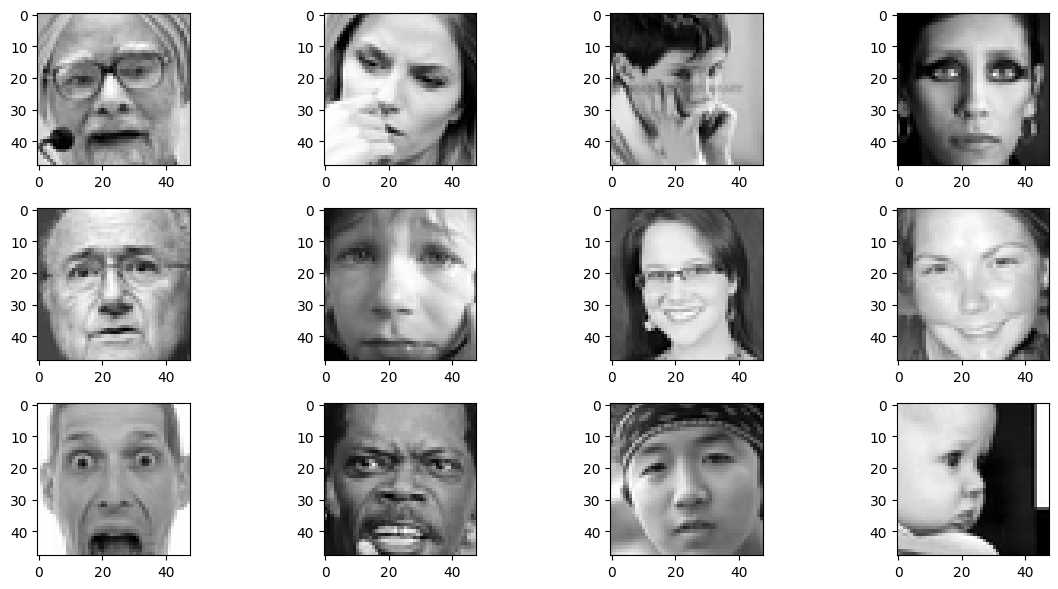

In [10]:
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(train_pixels[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

In [11]:
model_1 = models.Sequential()

model_1.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))

model_1.add(layers.MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model_1.add(layers.Flatten())

model_1.add(layers.Dense(1024, activation='relu'))
model_1.add(layers.Dropout(0.2))
model_1.add(layers.Dense(1024, activation='relu'))
model_1.add(layers.Dropout(0.2))

model_1.add(layers.Dense(7, activation='softmax'))


In [12]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 average_pooling2d (AverageP  (None, 7, 7, 64)         0         
 ooling2D)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 128)         7

In [13]:
model_1.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

history = model_1.fit(train_pixels, train_labels, batch_size = 256, epochs = 30,
                validation_data = (private_pixels, private_labels))

hist = pd.DataFrame(history.history)

Epoch 1/30
113/113 [==============================] - 4s 10ms/step - loss: 1.8188 - accuracy: 0.2471 - val_loss: 1.7954 - val_accuracy: 0.2541
Epoch 2/30
113/113 [==============================] - 1s 8ms/step - loss: 1.7508 - accuracy: 0.2751 - val_loss: 1.6707 - val_accuracy: 0.3357
Epoch 3/30
113/113 [==============================] - 1s 8ms/step - loss: 1.6157 - accuracy: 0.3564 - val_loss: 1.5671 - val_accuracy: 0.3787
Epoch 4/30
113/113 [==============================] - 1s 8ms/step - loss: 1.5237 - accuracy: 0.4039 - val_loss: 1.4781 - val_accuracy: 0.4249
Epoch 5/30
113/113 [==============================] - 1s 8ms/step - loss: 1.4502 - accuracy: 0.4395 - val_loss: 1.5079 - val_accuracy: 0.4074
Epoch 6/30
113/113 [==============================] - 1s 8ms/step - loss: 1.3868 - accuracy: 0.4634 - val_loss: 1.3786 - val_accuracy: 0.4678
Epoch 7/30
113/113 [==============================] - 1s 8ms/step - loss: 1.3298 - accuracy: 0.4907 - val_loss: 1.3306 - val_accuracy: 0.4901
Epoch

In [14]:
x = px.line(data_frame= hist , y= ["accuracy" , "val_accuracy"] ,markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Accuracy")
x.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [15]:
x = px.line(data_frame= hist , 
            y= ["loss" , "val_loss"] , markers = True )
x.update_xaxes(title="Number of Epochs")
x.update_yaxes(title = "Loss")
x.update_layout(showlegend = True,
    title = {
        'text': 'Loss vs Number of Epochs',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
x.show()

In [16]:
# Predict the probabilities for each class
predictions_prob = model_1.predict(public_pixels)
# Convert probabilities to class indices
predictions = np.argmax(predictions_prob, axis=1)

113/113 [==============================] - 0s 1ms/step


In [17]:
# Convert one-hot encoded labels to class indices
true_labels = np.argmax(public_labels, axis=1)

In [18]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

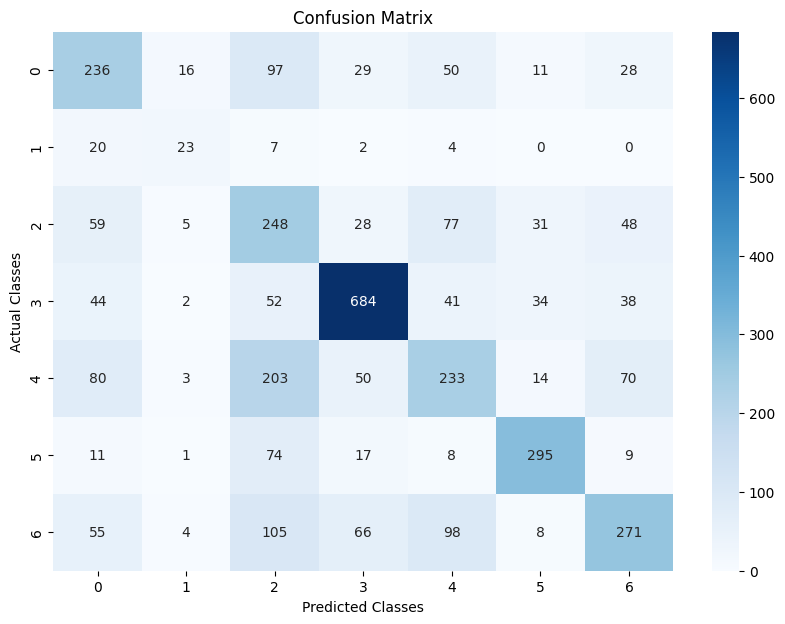

In [19]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4, 5, 6], yticklabels=[0, 1, 2, 3, 4, 5, 6])
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()

In [20]:
# Print classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.47      0.51      0.49       467
           1       0.43      0.41      0.42        56
           2       0.32      0.50      0.39       496
           3       0.78      0.76      0.77       895
           4       0.46      0.36      0.40       653
           5       0.75      0.71      0.73       415
           6       0.58      0.45      0.51       607

    accuracy                           0.55      3589
   macro avg       0.54      0.53      0.53      3589
weighted avg       0.57      0.55      0.56      3589



In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
import tensorflow as tf
import numpy as np

In [22]:
# Assuming public_pixels is your dataset and you want to predict the first instance
instance = public_pixels[0]

# Add an extra dimension to represent the batch size of 1
instance = np.expand_dims(instance, axis=0)

# Make a prediction
prediction = model_1.predict(instance)

# The output, prediction, is a probability distribution over all classes for this instance
print("Prediction (probability distribution over classes):", prediction)

# If you want the class with the highest probability
predicted_class = np.argmax(prediction, axis=1)
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 33ms/step
Prediction (probability distribution over classes): [[5.3071636e-01 3.6124546e-02 2.7418327e-01 1.7517639e-04 1.3401757e-01
  6.9431276e-03 1.7839964e-02]]
Predicted class: [0]


In [23]:
model_1.save('model/andres_model.keras')

In [24]:
def process_image(image_path):
    # Load the image with target size of 48x48
    img = image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')  # Use color_mode='grayscale' if your model expects grayscale images
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    
    # Normalize the image array
    img_array /= 255.0
    
    # Add a batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

FileNotFoundError: [Errno 2] No such file or directory: '../../User/split_input/face_2.jpg'